<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Code-setup" data-toc-modified-id="Code-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Code setup</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Read-in-ENM-data" data-toc-modified-id="Read-in-ENM-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Read in ENM data</a></span></li><li><span><a href="#ENM-data-frames" data-toc-modified-id="ENM-data-frames-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ENM data frames</a></span></li><li><span><a href="#ENM-WF-bins" data-toc-modified-id="ENM-WF-bins-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>ENM WF bins</a></span></li></ul></li><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pre-processing</a></span><ul class="toc-item"><li><span><a href="#Data-distributions" data-toc-modified-id="Data-distributions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data distributions</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Hierarchical-Agglomerative-Clustering-(HAC)" data-toc-modified-id="Hierarchical-Agglomerative-Clustering-(HAC)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Hierarchical Agglomerative Clustering (HAC)</a></span><ul class="toc-item"><li><span><a href="#Similarity-heatmap" data-toc-modified-id="Similarity-heatmap-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Similarity heatmap</a></span></li><li><span><a href="#Dendrograms-and-elbow-graph" data-toc-modified-id="Dendrograms-and-elbow-graph-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Dendrograms and elbow graph</a></span></li><li><span><a href="#Helper-class-for-selecting-best-ENM-estimator" data-toc-modified-id="Helper-class-for-selecting-best-ENM-estimator-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Helper class for selecting best ENM estimator</a></span></li><li><span><a href="#Gridsearch-to-select-n_clusters" data-toc-modified-id="Gridsearch-to-select-n_clusters-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Gridsearch to select n_clusters</a></span></li><li><span><a href="#Apply-feature-agglomeration" data-toc-modified-id="Apply-feature-agglomeration-3.3.5"><span class="toc-item-num">3.3.5&nbsp;&nbsp;</span>Apply feature agglomeration</a></span></li><li><span><a href="#Concatenate-final-dataframe" data-toc-modified-id="Concatenate-final-dataframe-3.3.6"><span class="toc-item-num">3.3.6&nbsp;&nbsp;</span>Concatenate final dataframe</a></span></li></ul></li></ul></li><li><span><a href="#Preliminary-models" data-toc-modified-id="Preliminary-models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preliminary models</a></span></li></ul></div>

# Code setup

In [105]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# To suppress warning output
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Important imports
import numpy as np
from numpy import random
import pandas as pd
import os, sys

In [106]:
# Set random seed across notebook for repeatable results
np.random.seed(24)

In [107]:
# To plot nice figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
plt.rcParams['axes.titlesize'] = 'x-large' #16
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'

In [108]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "figs"

if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
    print('Figure directory did not exist, creating now.')
    os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
else:
    print('Figure directory exists.')

Figure directory exists.


In [112]:
# Import classes and functions used across multiple notebooks
sys.path.append(os.getcwd())
import importlib
import functions as blt
importlib.reload(blt);

Figure directory exists.


# Data

## Read in ENM data

In [47]:
# Read in engineered nanomaterials (ENM) weight fraction data and 
# potential predictive variables
X_enm = pd.read_csv("./data/ENM-clean.csv", sep=',', header='infer')

# Drop unwanted columns
    # For PUC, keeping getcat, group, refined, assigned ("matrix")
    # Drop dehydrating_agent[22], dispersing_agent[24], fuel_agent[27]
X_enm.drop(X_enm.columns[[0,1,2,3,4,9,12,22,24,27,34,35,36]], 
           axis=1, inplace=True)    

# Rename columns
X_enm.rename(columns = {'gencatID':'gen'}, inplace=True)
X_enm.rename(columns = {'refined_product_type':'refined'}, inplace=True)
X_enm.rename(columns = {'assignedID':'matrix'}, inplace=True)
X_enm.rename(columns={'measured':'WF_measured'}, inplace=True)
X_enm.rename(columns={'antistain_agent':'antiredeposition_agent'}, 
             inplace=True)
X_enm.rename(columns={'lubricating_agent':'anti_adhesive_cohesive'}, 
             inplace=True)

In [48]:
# Find and replace (clean data)

# To maintain atomicity, assign all child-specific products (C) as articles (A) 
# and all OTC pharmaceuticals (P) as formulas (F) (they were all liquids)
X_enm['matrix'] = X_enm['matrix'].replace('C','A', regex=True)
X_enm['matrix'] = X_enm['matrix'].replace('P','F', regex=True)

# Clean up data in refined column so it's only spray vs NOC
X_enm['refined'] = X_enm['refined'].replace('child','NOC', regex=True)
X_enm['refined'] = X_enm['refined'].replace('exterior','NOC', regex=True)
X_enm['refined'] = X_enm['refined'].replace('interior','NOC', regex=True)
X_enm['refined'] = X_enm['refined'].replace('soft','NOC', regex=True)
X_enm['refined'] = X_enm['refined'].replace('plastic','NOC', regex=True)

In [49]:
# Transform factor data (product categories) into binary columns
X_enm=pd.get_dummies(X_enm, 
                     prefix=["gen","group","refined","matrix"], 
                     columns=["gen","group","refined","matrix"])

# Remove spaces from column names
X_enm.columns = X_enm.columns.str.replace(' ','')
X_enm.columns = X_enm.columns.str.replace('/','')
X_enm.columns = X_enm.columns.str.replace('-','')

# Drop columns absent from organics
X_enm.drop(['gen_AP','gen_CS','gen_FC','gen_PH','group_apparel',
            'group_coldrelief','group_firstaid','group_foodstorage',
            'group_largeappliances','group_nutritionalsupplements',
            'group_portableairprocessing','group_toys',
            'refined_NOC','matrix_A'], 
           axis=1, inplace=True)

# Rearrange feature order
cols = X_enm.columns.tolist()
cols = cols[:5] + [cols[16]] + cols[5:16] + cols[17:] # Move anti_adh... up
cols = cols[:20] + cols[21:] + [cols[20]]             # WF_measured to end
X_enm = X_enm[cols]

In [50]:
list(X_enm.columns)

['propMW',
 'propMP',
 'propBP',
 'propDensity',
 'absorbent',
 'anti_adhesive_cohesive',
 'antioxidant',
 'antiredeposition_agent',
 'biocide',
 'brightener',
 'chemical_reaction_regulator',
 'colorant',
 'deodorizer',
 'filler',
 'flavouring_nutrient',
 'hardener',
 'humectant',
 'opacifier',
 'uv_stabilizer',
 'viscosity_modifier',
 'gen_AC',
 'gen_CP',
 'gen_EL',
 'gen_HM',
 'gen_PC',
 'gen_PE',
 'gen_VE',
 'group_childspecific',
 'group_dentalcare',
 'group_deodorant',
 'group_enginemaintenance',
 'group_fabrictreatmentanddye',
 'group_facialcleansingandmoisturizing',
 'group_fungicide',
 'group_generalhouseholdcleaning',
 'group_generalmoisturizing',
 'group_makeupandrelated',
 'group_paintstainandrelatedproducts',
 'group_sunscreen',
 'group_surfacesealers',
 'refined_spray',
 'matrix_F',
 'WF_measured']

In [51]:
# Export column headings list
cols = X_enm.columns.tolist()
with open('./data/column-headers.txt', 'w') as filehandle:  
    for listitem in cols:
        filehandle.write('%s\n' % listitem)
cols

['propMW',
 'propMP',
 'propBP',
 'propDensity',
 'absorbent',
 'anti_adhesive_cohesive',
 'antioxidant',
 'antiredeposition_agent',
 'biocide',
 'brightener',
 'chemical_reaction_regulator',
 'colorant',
 'deodorizer',
 'filler',
 'flavouring_nutrient',
 'hardener',
 'humectant',
 'opacifier',
 'uv_stabilizer',
 'viscosity_modifier',
 'gen_AC',
 'gen_CP',
 'gen_EL',
 'gen_HM',
 'gen_PC',
 'gen_PE',
 'gen_VE',
 'group_childspecific',
 'group_dentalcare',
 'group_deodorant',
 'group_enginemaintenance',
 'group_fabrictreatmentanddye',
 'group_facialcleansingandmoisturizing',
 'group_fungicide',
 'group_generalhouseholdcleaning',
 'group_generalmoisturizing',
 'group_makeupandrelated',
 'group_paintstainandrelatedproducts',
 'group_sunscreen',
 'group_surfacesealers',
 'refined_spray',
 'matrix_F',
 'WF_measured']

In [52]:
# Log-transform density so that it is no longer skewed
X_enm['propLogDensity'] = X_enm['propDensity'].apply(np.log10)

# Replace propDensity with propLogDensity in data frame
cols = X_enm.columns.tolist()
cols = cols[:3] + cols[-1:] + cols[4:-1]
X_enm = X_enm[cols]

In [54]:
# Read in ENM maximum_weight_fraction data
y_enm = pd.read_csv("./data/ENM-clean.csv", 
                    sep=',', header='infer', usecols=[3])

## ENM data frames

Split ENM-WF into separate dataframes.

In [56]:
# Dataframe for ENM functional use and product categories
Xfp_enm=pd.DataFrame(X_enm)

# Drop unwanted columns
Xfp_enm.drop(Xfp_enm.columns[0:4], axis=1, inplace=True) # drop chem props
Xfp_enm.drop(Xfp_enm.columns[-3:], axis=1, inplace=True) # drop last 3 columns

# Column names
enm_all_names=list(Xfp_enm.columns.values)

In [58]:
# Dataframe for only ENM functional use categories
Xf_enm=pd.DataFrame(X_enm)

# Drop unwanted columns
Xf_enm.drop(Xf_enm.columns[0:4], axis=1, inplace=True) # drop chem props
Xf_enm.drop(Xf_enm.columns[16:], axis=1, inplace=True) # drop PUC
enm_func_names=list(Xf_enm.columns.values)

In [61]:
# Dataframe for only ENM product categories
Xp_enm=pd.DataFrame(X_enm)

# Drop unwanted columns
Xp_enm.drop(Xp_enm.columns[0:20], axis=1, inplace=True)
Xp_enm.drop(Xp_enm.columns[-3:], axis=1, inplace=True) # drop last 3 columns
enm_PUC_names=list(Xp_enm.columns.values)

In [63]:
# Array for only chemical properties
Xc_enm=pd.DataFrame(X_enm)

# Drop unwanted columns
Xc_enm.drop(Xc_enm.columns[4:], axis=1, inplace=True)
list(Xc_enm.columns.values)

['propMW', 'propMP', 'propBP', 'propLogDensity']

In [64]:
# Dataframe for only ENM [product] matrix categories
Xm_enm=pd.DataFrame(X_enm)

# Drop unwanted columns
Xm_enm.drop(Xm_enm.columns[:-3], axis=1, inplace=True)
list(Xm_enm.columns.values)

['refined_spray', 'matrix_F', 'WF_measured']

Note that 'WF_measured' is not actually a matrix property; it describes whether the WF was verified with lab analysis or if it was simply claimed by the manufacturer.

## ENM WF bins

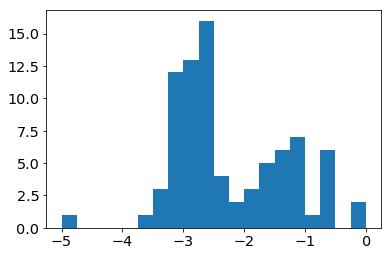

In [65]:
# Log-transformed histogram of weight fraction
plt.hist(np.log10(np.asarray(y_enm)), bins=20);

In [66]:
# Apply bins to ENM and organics data
# (slightly different ranges from those used by Isaacs et al. 2016)
bin_enm = np.asarray(y_enm.apply(blt.bins, axis=1))

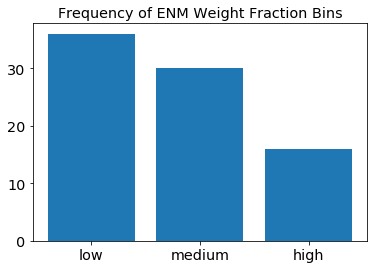

Label bin:  [0 1 2]
Count    :  [36 30 16]
Frequency:  [0.44, 0.37, 0.2]


In [104]:
# View bar plot of ENM WF bins
blt.bar_graph_bins(bin_enm, data_composition='ENM')

# Pre-processing

## Data distributions

In [68]:
# Function for plotting piecharts
def plot_piechart(data,
                  labels, 
                  save_fig_name):
    my_colors = ["#1f77b4","#ff7f0e","#ffdf00","#d62728","#9467bd",
                 "#2ca02c","#1034A6","#ffbf33","#8B0000",'teal',
                 "#aada30","#e37799","#17becf","#7f7f7f","#cc0099","#0B6623"]
    fig, ax = plt.subplots(figsize=(6,6))
    ax.pie(data, autopct='%1.1f%%', 
           colors=my_colors, 
           labels=labels, 
           pctdistance=0.9, labeldistance=1.05, 
           startangle=90, counterclock=False, 
           textprops={'fontsize':9})
    ax.axis('equal')
    ax.set_title(save_fig_name, weight="bold")
    fig.savefig('./figs/pie_%s.png' 
                % save_fig_name.lower().replace(' ','_'))
    plt.show()

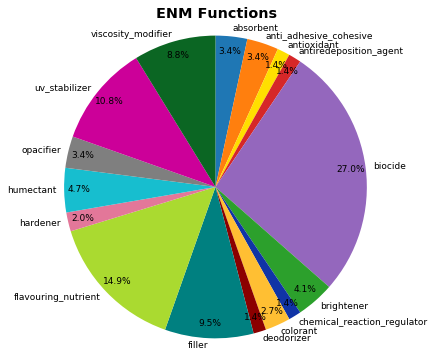

In [69]:
# ENM function breakdown as pie chart
plot_piechart(data=Xf_enm.sum(axis=0), 
              labels=enm_func_names, 
              save_fig_name='ENM Functions')

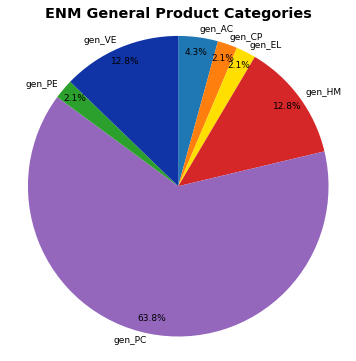

In [70]:
# ENM PUC breakdown as pie chart
plot_piechart(data=Xp_enm.values[:,0:7].sum(axis=0), 
              labels=enm_PUC_names[0:7], 
              save_fig_name='ENM General Product Categories')

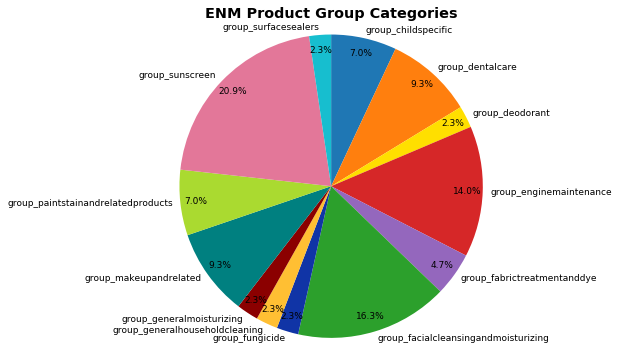

In [71]:
# ENM PUC breakdown as pie chart
plot_piechart(data=Xp_enm.values[:,7:].sum(axis=0), 
              labels=enm_PUC_names[7:], 
              save_fig_name='ENM Product Group Categories')

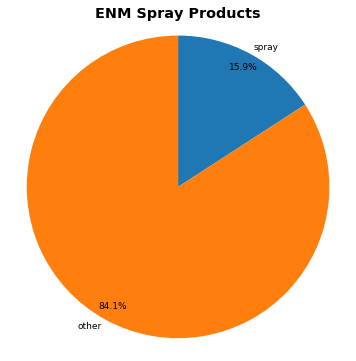

In [72]:
# ENM PUC breakdown as pie chart
labels = ['spray','other']
values = [(np.count_nonzero(X_enm['refined_spray'])), 
          (len(X_enm['refined_spray']) \
           - np.count_nonzero(X_enm['refined_spray']))]
plot_piechart(data=values, 
              labels=labels, 
              save_fig_name='ENM Spray Products')

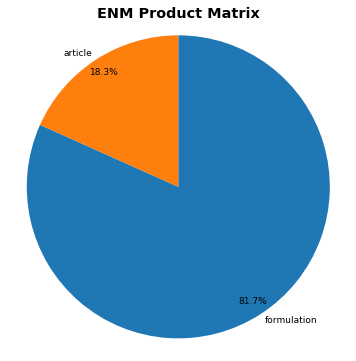

In [73]:
# ENM product matrices as pie chart
labels = ['formulation','article']
values = [(np.count_nonzero(X_enm['matrix_F'])), 
          (len(X_enm['matrix_F']) - np.count_nonzero(X_enm['matrix_F']))]
plot_piechart(data=values, 
              labels=labels, 
              save_fig_name='ENM Product Matrix')

## PCA

In [74]:
# Scale the data first (i.e., chemical properties) so everything is from 0 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_enm_scaled = scaler.fit_transform(X_enm)

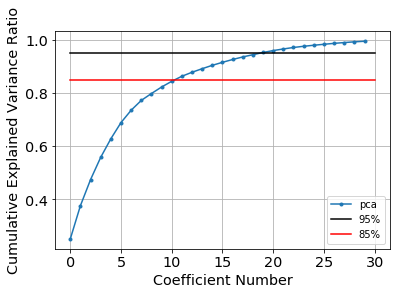

In [75]:
# Figure out number of components to achieve 85% cumulative explained variance
from sklearn import decomposition 
pca=decomposition.PCA(n_components=30)
dim_red_enm=pca.fit(X_enm_scaled)

fig =plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_),'.-',label='pca')
plt.plot([0, 30],[.95,.95],'k',label='95%')
plt.plot([0, 30],[.85,.85],'r',label='85%')
plt.xlabel('Coefficient Number')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid()
plt.legend()
plt.show()

In [76]:
# Transform/apply PCA
from sklearn import decomposition 
pca = decomposition.PCA(n_components=11)
dim_red_enm = pd.DataFrame(pca.fit_transform(X_enm_scaled))

# Export PCA dataframe
dim_red_enm.to_csv("./data/ENM-PCA-feats.csv", sep='\t', na_rep='', 
              header=True, index=True, index_label=None, mode='w')

## Hierarchical Agglomerative Clustering (HAC)

* Feature Agglomeration sklearn http://scikit-learn.org/stable/modules/generated/sklearn.cluster.FeatureAgglomeration.html
* Alternate approach
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
* Distance matrix with Jaccard similarity: https://stackoverflow.com/questions/35639571/python-pandas-distance-matrix-using-jaccard-similarity

### Similarity heatmap

In [77]:
# Function for distance matrix, selecting n_clusters
from scipy.spatial.distance import squareform, pdist, cosine, jaccard
from scipy.cluster.hierarchy import dendrogram, linkage

def similarity_heatmap(feature_data, 
                       feature_names, 
                       save_fig_name, 
                       dist_metric='cosine'):
    
    # Transform to find distance between features (not datapoints)
    sim = 1- pdist(feature_data.T, dist_metric)
    
    # Make matrix
    sim_matrix = pd.DataFrame(squareform(sim), 
                               index=feature_names, 
                               columns=feature_names)
    
    # Plot matrix
    from textwrap import wrap
    fig = plt.imshow(sim_matrix)
    plt.title("\n".join(wrap('%s\nSimilarity Matrix of Features (%s)' 
                             % (dist_metric.title(), 
                                save_fig_name.title()), 60)))
    plt.colorbar()
    plt.savefig('./figs/enm_similarmatrix_%s_%s.png' 
                % (save_fig_name, dist_metric))

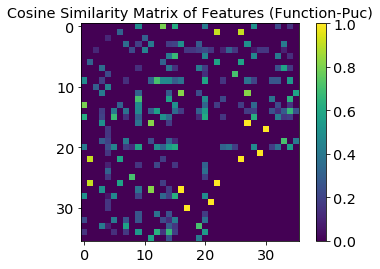

In [78]:
# Similarity matrix
# ENM Function and PUC features
similarity_heatmap(Xfp_enm, 
                   feature_names=enm_all_names, 
                   save_fig_name='function-PUC')

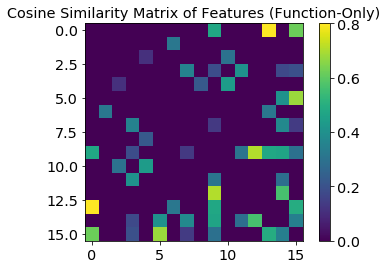

In [79]:
# Similarity matrix
# ENM Function features
similarity_heatmap(Xf_enm, 
                   feature_names=enm_func_names, 
                   save_fig_name='function-only')

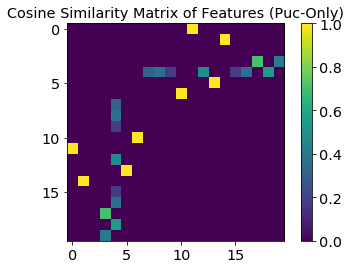

In [80]:
# Similarity matrix
# ENM PUC features
similarity_heatmap(Xp_enm, 
                   feature_names=enm_PUC_names, 
                   save_fig_name='PUC-only')

### Dendrograms and elbow graph

Optimize the number of clusters using the elbow method, which estimates the clustering step where the acceleration of distance growth is largest (indicated by the dashed gray line on the dendrogram).

In [81]:
# Define function to visualize best parameter options for clustering
from scipy.spatial.distance import pdist, cosine
from scipy.cluster.hierarchy import dendrogram, linkage

def optimize_clustering(feature_data,
                        feature_names,
                        save_fig_name):
    
    # Calculate cosine distance and features to be clustered 
    # Z-array has format [idx1, idx2, dist, sample_count]
    Z = linkage((feature_data.T), method='average', metric='cosine')
    
    # Calculations for elbow graph
    last = Z[-len(Z):, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)
    acceleration = np.diff(last, 2)  # 2nd derivative of the distances
    acceleration_rev = acceleration[::-1]
    
    # Find the 5 best contenders for optimal n_clusters
    n = acceleration_rev.argmax() + 2  # if idx 0 is the max, want 2 clusters
    top_n_clusters = acceleration_rev.argsort()[::-1][:5] + 2
    
    # Calculate best clustering threshold for dendrogram
    cutoff_idx = len(feature_data.T) - n - 1
    cutoff_dist = Z[cutoff_idx,2]
    
    # Report optimal n_clusters with Elbow Method
    plt.plot(idxs, last_rev, label='distance')
    plt.plot(idxs[:-2] + 1, acceleration_rev, label='acceleration')
    plt.title('Elbow Method to Determine n_clusters for %s Features' 
              % save_fig_name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
    plt.savefig('./figs/enm_elbow_%s.png' % save_fig_name)
    plt.show()

    print("Optimal(?) n_clusters:", n)   
    print("Contending n_clusters:", top_n_clusters)
    
    # Plot and save dendrogram
    fig=plt.figure(figsize=(30, 15))
    plt.title('Hierarchical Clustering Dendrogram (%s)' % save_fig_name)
    plt.xlabel('Feature Index')
    plt.ylabel('Distance')
    dendrogram(Z,
               leaf_rotation=90.,   # rotates the x axis labels
               leaf_font_size=14.,  # font size for the x axis labels
               labels=feature_names)
    plt.axhline(y=cutoff_dist, color='gray', linestyle='--',
               label="cluster threshold")
    plt.show()
    fig.savefig('./figs/enm_cluster_dendrogram_%s' % save_fig_name)
    
    return top_n_clusters

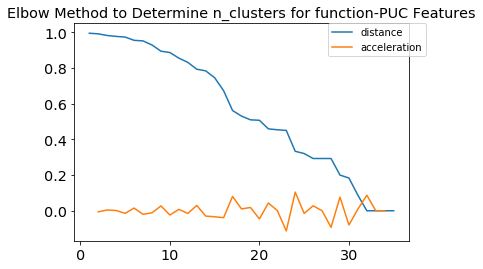

Optimal(?) n_clusters: 24
Contending n_clusters: [24 32 17 29 21]


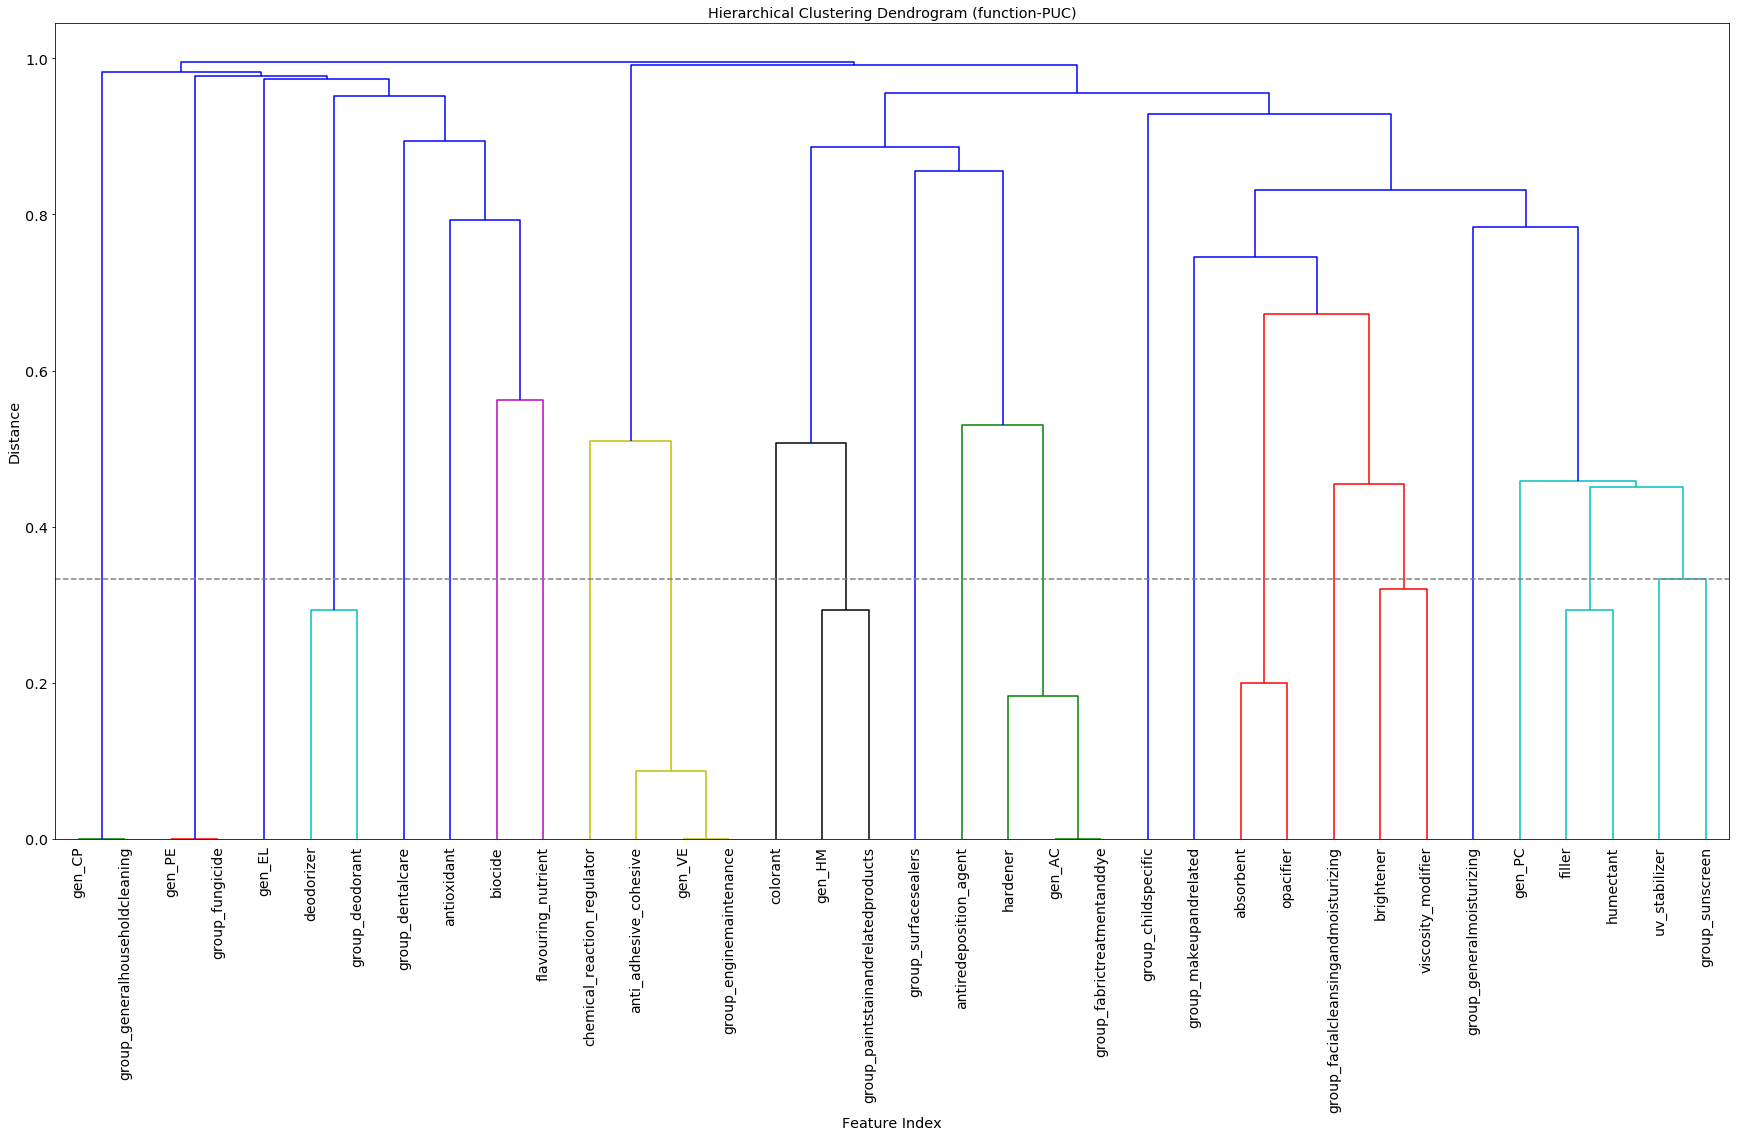

In [82]:
# Similarity matrix
# ENM Function and PUC features
cluster_set_fp = optimize_clustering(Xfp_enm, 
                                     feature_names=enm_all_names, 
                                     save_fig_name='function-PUC')

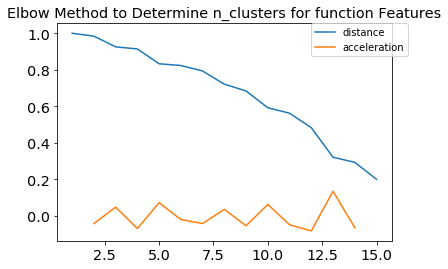

Optimal(?) n_clusters: 13
Contending n_clusters: [13  5 10  3  8]


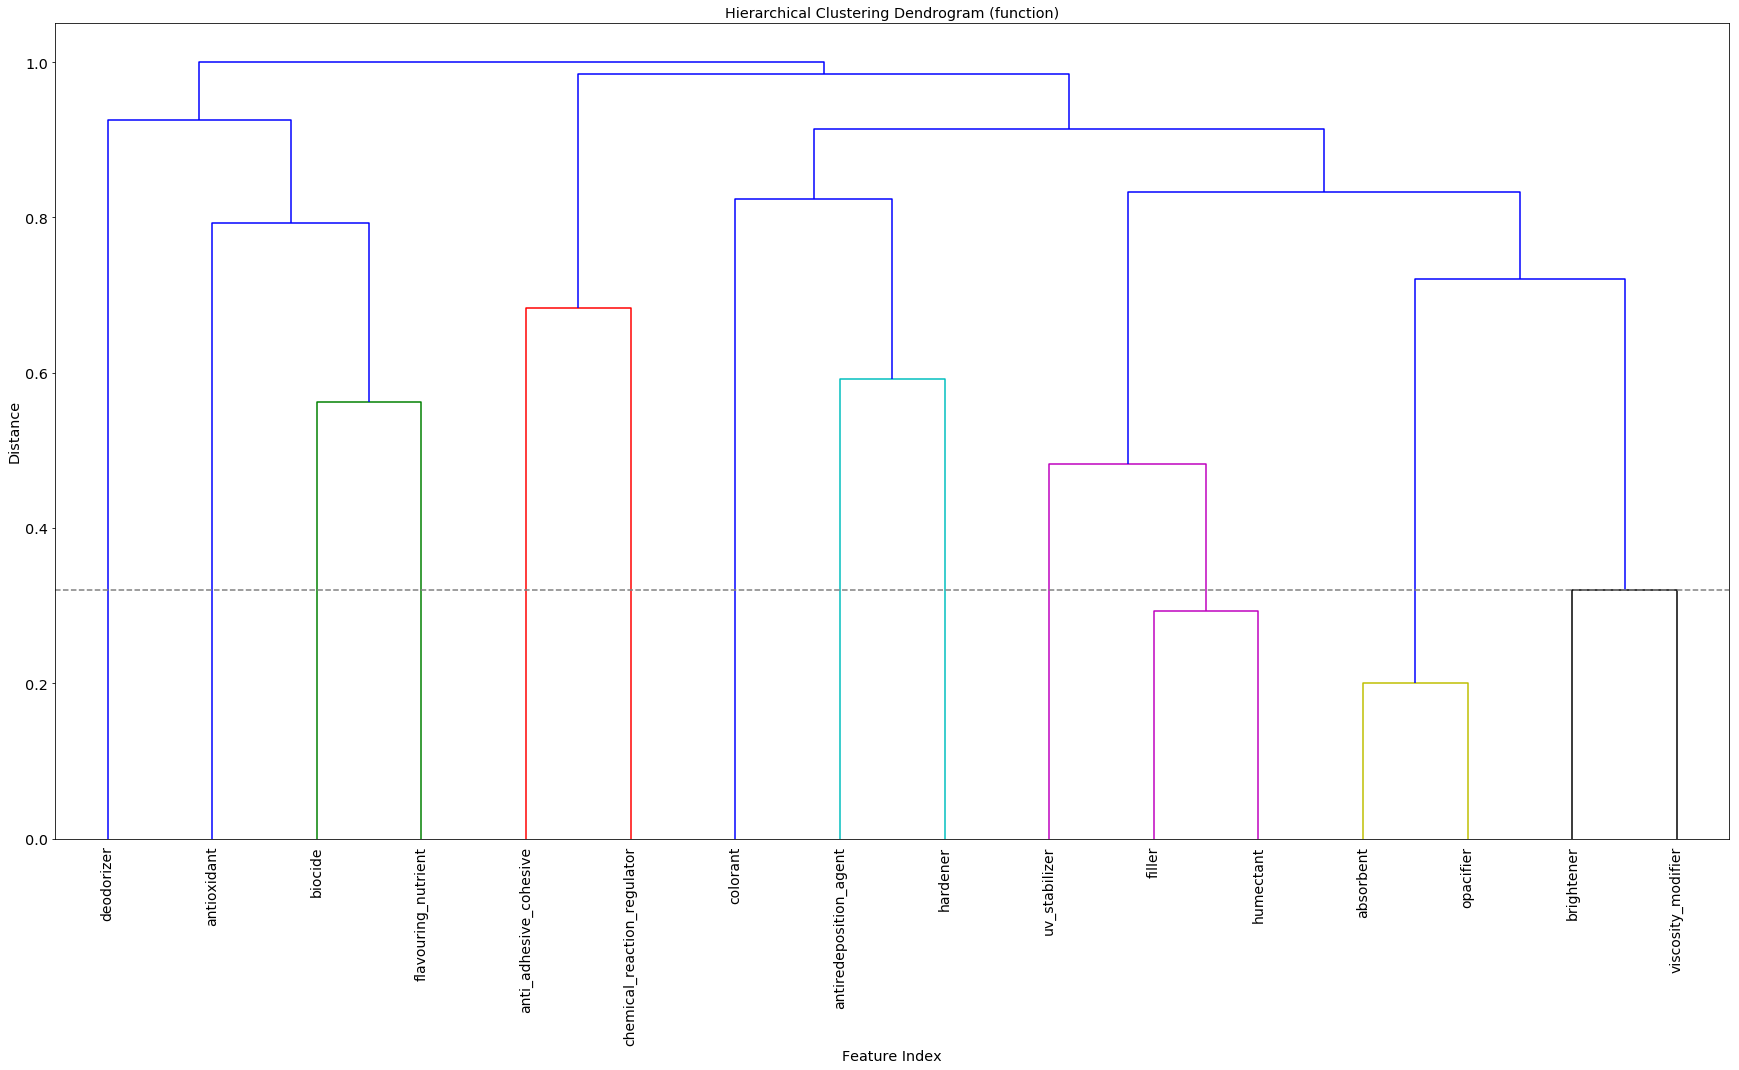

In [83]:
# Elbow graph and dendrogram
# ENM functions only
cluster_set_f = optimize_clustering(Xf_enm, 
                                    feature_names=enm_func_names, 
                                    save_fig_name='function')

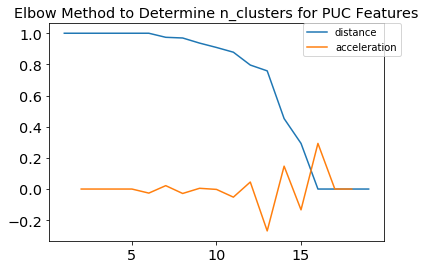

Optimal(?) n_clusters: 16
Contending n_clusters: [16 14 12  7  9]


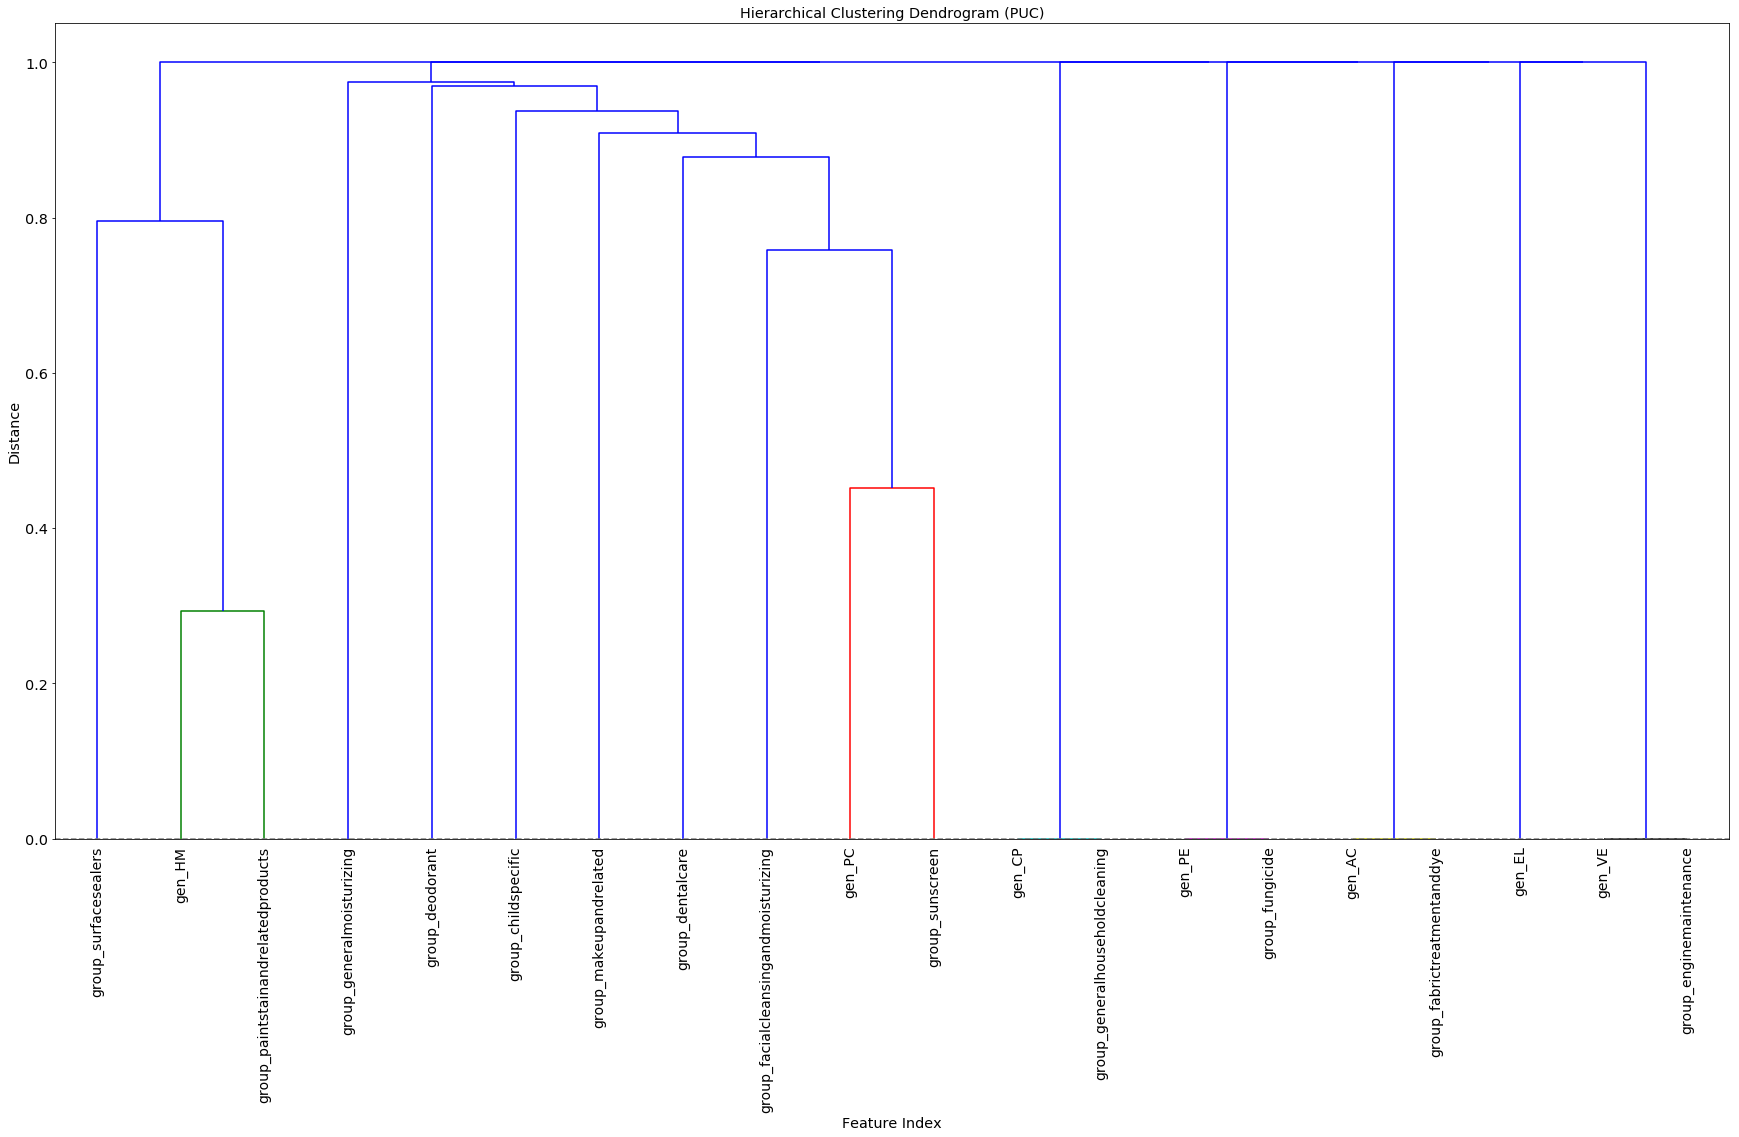

In [84]:
# Elbow graph and dendrogram
# ENM PUC features
cluster_set_p = optimize_clustering(Xp_enm, 
                                    feature_names=enm_PUC_names, 
                                    save_fig_name='PUC')

### Helper class for selecting best ENM estimator

In [85]:
# Define sets of models and their respective parameters to compare
# The first dictionary contains the models to be scored
# while the second contains the parameters for each model

from sklearn.cluster import FeatureAgglomeration
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

models = {
    'RFC': RandomForestClassifier(class_weight='balanced'),
    'SVC': SVC(class_weight='balanced')
}
params = {
    'RFC': {'max_depth': [2,4,6,8]},
    'SVC': [{'kernel': ['linear'], 
             'C': np.logspace(-1,7,9)},
            {'kernel': ['rbf'], 
             'C': np.logspace(-1,7,9), 
             'gamma': np.logspace(-7,1,9)},
           ]
}

In [86]:
# Fit gridsearch models to select best estimator based on accuracy
helper = blt.EstimatorSelectionHelper(models, params)
helper.fit(Xfp_enm, bin_enm, n_jobs=3)
helper.score_summary(sort_by='mean_score')

Running GridSearchCV for RFC.
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 out of  40 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:    2.4s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for SVC.
Fitting 10 folds for each of 90 candidates, totalling 900 fits
RFC
SVC


[Parallel(n_jobs=3)]: Done 900 out of 900 | elapsed:   23.4s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,max_depth
76,SVC,0.428571,0.615873,1,0.203125,1e+06,1e-07,rbf,NaN
36,SVC,0.428571,0.615873,1,0.203125,10,0.01,rbf,NaN
28,SVC,0.428571,0.601587,0.888889,0.179225,1,0.1,rbf,NaN
2,RFC,0.333333,0.593651,1,0.208439,NaN,NaN,NaN,6
60,SVC,0.428571,0.593651,1,0.183222,10000,1e-05,rbf,NaN
52,SVC,0.428571,0.593651,1,0.183222,1000,0.0001,rbf,NaN
68,SVC,0.428571,0.593651,1,0.183222,100000,1e-06,rbf,NaN
44,SVC,0.428571,0.593651,1,0.183222,100,0.001,rbf,NaN
45,SVC,0.333333,0.58254,0.888889,0.182097,100,0.01,rbf,NaN
5,SVC,0.333333,0.571429,0.888889,0.180003,1,NaN,linear,NaN


The best performing classifier was the SVC-RBF. This will be used in subsequent pre-processing steps.

### Gridsearch to select n_clusters

The top few n_clusters found using elbow graphs in addition to the maximum number of clusters (i.e., no agglomeration), are evaluated using an SVC-RBF (supervised learning) to determine the final n_clusters. This is done using a gridsearch function.

In [87]:
# TODO: breaks on contour plot when search includes third parameter

# Define function to optimize and perform SVC-RBF with accuracy scoring
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import FeatureAgglomeration
from sklearn.svm import SVC
from sklearn.svm import SVR
import random

def gridsearch_svm(X_training, 
                   y_training, 
                   n_clusters_set=None, 
                   c_set=np.logspace(-1,7,17), 
                   gamma_set=np.logspace(-7,1,17), 
                   plot_contour=False):
    """
    This function searches the specified grid of C and gamma values for the 
    optimal parameter values with which to run SVC-RBF, then returns the best 
    values based on validation accuracy. 
    
    Parameters
    ----------
    n_clusters_set: array of int (default=None)
        Includes feature agglomeration in pipeline using the specified array of
        cluster numbers to try out
    plot_contour: bool (default=False)
        `True` will plot accuracy as contour lines on the 
        specified parameter grid.   
    """ 
    
    # Define pipelines and parameters for the grid search
    seed = random.randint(1,100)
    if isinstance(y_training[0], float):
        estimator = SVR(kernel='rbf', random_state=seed)
        scoring = 'explained_variance'
    else:
        estimator = SVC(kernel='rbf', 
                        class_weight='balanced', 
                        random_state=seed)
        scoring = 'balanced_accuracy'
    if np.all(n_clusters_set == None):
        prepipe = Pipeline([('scale', MinMaxScaler()), 
                            ('estimator', estimator)
                           ])
        param_grid = {'estimator__C': c_set,
                      'estimator__gamma': gamma_set
                     }
    else:
        agg = FeatureAgglomeration(X_training, 
                                   affinity="cosine", 
                                   linkage="average")
        prepipe = Pipeline([('agg', agg), 
                            ('estimator', estimator)
                           ])
        param_grid = {'agg__n_clusters': n_clusters_set, 
                      'estimator__C': c_set, 
                      'estimator__gamma': gamma_set
                     }

    # Grid search with CV to find best model parameters
    n_jobs = 3
    cv = 17
    grid_search = GridSearchCV(prepipe, 
                               param_grid, 
                               cv=cv, 
                               scoring=scoring, 
                               n_jobs=n_jobs, 
                               pre_dispatch=2*n_jobs)
    grid_search.fit(X_training, y_training)
    C = grid_search.best_params_.get('estimator__C')
    gamma = grid_search.best_params_.get('estimator__gamma')
    print(grid_search.best_params_)
    print('K-fold CV random state: ', seed)
    print('Best fold',grid_search.scoring, ':    ',grid_search.best_score_)
    
    # Optional contour plot
    if plot_contour:
        test_scores = np.reshape(grid_search.cv_results_.get('mean_test_score'), 
                                 newshape=[-1, len(gamma_set)])
        fig = plt.figure()
        plt.contourf(np.log10(gamma_set), 
                    np.log10(c_set), 
                    test_scores)
        plt.title('Accuracy over parameter grid')
        plt.xlabel('log_10(gamma)')
        plt.ylabel('log_10(C)')
        plt.colorbar()
        plt.show()
    
    return C, gamma

Have to run fit with [X + a very small number] so that features with very few ones don't go missing during cross validation. https://stats.stackexchange.com/questions/324732/kernel-density-estimator-kde-with-too-many-zeroes-as-input

In [88]:
# Function features only
gridsearch_svm(Xf_enm+0.0001, 
               bin_enm, 
               n_clusters_set=np.append(cluster_set_f, len(Xf_enm.columns)), 
               c_set=np.logspace(-1,7,17), 
               gamma_set=np.logspace(-7,1,17))

{'agg__n_clusters': 8, 'estimator__C': 10.0, 'estimator__gamma': 0.01}
K-fold CV random state:  5
Best fold balanced_accuracy :     0.625


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(10.0, 0.01)

In [90]:
# PUC features only
gridsearch_svm(Xp_enm+0.0001, 
               bin_enm, 
               n_clusters_set=cluster_set_p, 
               c_set=np.logspace(-1,7,17), 
               gamma_set=np.logspace(-7,1,17))

{'agg__n_clusters': 16, 'estimator__C': 1.0, 'estimator__gamma': 1.0}
K-fold CV random state:  65
Best fold balanced_accuracy :     0.5853658536585366


(1.0, 1.0)

### Apply feature agglomeration

A more conservative approach to feature agglomeration was taken. Only features that had the same similarity were combined.

In [91]:
# Apply feature agglomeration
from sklearn.cluster import FeatureAgglomeration

# PUC feature agglomeration
agg = FeatureAgglomeration(n_clusters=16, affinity="cosine", linkage="average")
agg.fit(Xp_enm+0.0001)
Xp_enm_red = pd.DataFrame(agg.transform(Xp_enm))

In [92]:
cols_Xp_red = [
    'agg_PE_fungicide', #0
    'agg_CP_generalhouseholdcleaning', #1
    'agg_VE_enginemaintenance', #2
    'agg_AC_fabrictreatmentanddye', #3
    'group_paintstainandrelatedproducts', #4
    'group_surfacesealers', #5
    'group_facialcleansingandmoisturizing', #6
    'group_generalmoisturizing', #7    
    'group_deodorant', #8
    'group_childspecific', #9
    'group_makeupandrelated', #10
    'group_dentalcare', #11
    'group_sunscreen', #12
    'gen_EL', #13
    'gen_PC', #14
    'gen_HM', #15    
    ]
Xp_enm_red.columns = cols_Xp_red
cols_Xp_red.sort()
Xp_enm_red = Xp_enm_red[cols_Xp_red]

### Concatenate final dataframe

In [103]:
# Concatenate all clustered and unscaled features into new dataframe
XX_enm = pd.concat([Xc_enm, Xf_enm, Xp_enm_red, Xm_enm], axis=1)
XX_enm.tail(4)

,propMW,propMP,propBP,propLogDensity,absorbent,anti_adhesive_cohesive,antioxidant,antiredeposition_agent,biocide,brightener,...,group_deodorant,group_facialcleansingandmoisturizing,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F,WF_measured
78,81.370,1975.00,2360.0,0.748576,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
79,60.085,1600.00,2230.0,0.413551,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1
80,79.867,1843.00,2972.0,0.626340,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1
81,107.868,961.78,2162.0,1.014730,0,0,0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1


In [94]:
# Export unscaled ENM dataframe
XX_enm.to_csv("./data/ENM-preprocessed-feats.csv", sep='\t', na_rep='', 
              header=True, index=True, index_label=None, mode='w')

# Preliminary models

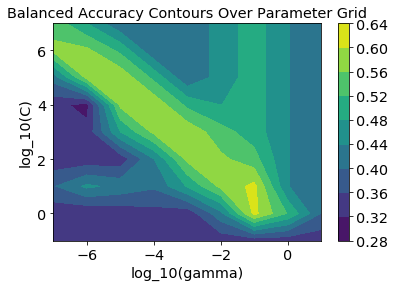

Random state:	 69
Best parameters: {'C': 1.0, 'gamma': 0.1}
Max opt. balanced accuracy: 0.611
Avg. balanced accuracy:     0.608
Normalized Confusion Matrix
[[0.86 0.03 0.11]
 [0.47 0.4  0.13]
 [0.25 0.19 0.56]]


0.6078703703703704

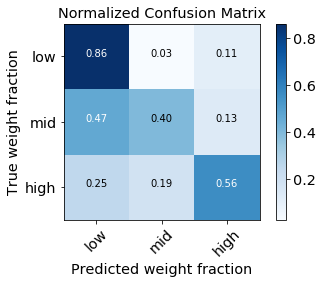

In [110]:
# Clustered ENM-only data using larger parameter space
param_grid = {'estimator__C': np.logspace(-1,7,9), 
              'estimator__gamma': np.logspace(-7,1,9)
             }
blt.model_opt_exe(classifier='svc', 
                  aug_type='none', 
                  k=0, 
                  feat_data=XX_enm+0.0001, 
                  bin_data=bin_enm, 
                  seed=69, 
                  show_opt_plot=True, 
                  show_cnf_matrix=True, 
                  param_grid=param_grid)

In [111]:
# Multiple trials SVC-RBF, balanced accuracy
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': XX_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
blt.multi_trials(num_trials=100, 
                 model_params=model_params, 
                 print_results=True)

Avg accuracy:     0.617
Median accuracy:  0.612
StdDev accuracy:  0.011
Numer of trials:  100
Results:  [0.61, 0.61, 0.61, 0.61, 0.61, 0.63, 0.62, 0.63, 0.61, 0.61, 0.62, 0.62, 0.61, 0.62, 0.63, 0.61, 0.61, 0.61, 0.61, 0.64, 0.61, 0.61, 0.64, 0.63, 0.63, 0.61, 0.61, 0.64, 0.62, 0.61, 0.63, 0.64, 0.62, 0.64, 0.61, 0.61, 0.62, 0.63, 0.62, 0.62, 0.61, 0.61, 0.61, 0.62, 0.61, 0.62, 0.61, 0.6, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.65, 0.59, 0.62, 0.62, 0.61, 0.61, 0.61, 0.62, 0.63, 0.62, 0.61, 0.62, 0.63, 0.61, 0.61, 0.63, 0.64, 0.61, 0.62, 0.61, 0.63, 0.61, 0.61, 0.61, 0.61, 0.62, 0.61, 0.61, 0.63, 0.61, 0.63, 0.61, 0.63, 0.59, 0.63, 0.62, 0.61, 0.6, 0.61, 0.61, 0.61, 0.61, 0.63, 0.62, 0.61, 0.63]


(0.617, 0.011)